In [1]:
# This will be the main file used to train the data

In [2]:
import os

In [3]:
# Establish directories
basedir =  os.getcwd()
traindir = os.path.join(basedir, "train")
validationdir = os.path.join(basedir, "validation")
testdir = os.path.join(basedir, "test")

In [4]:
# Tweek dropout layer

In [5]:
class_num = 8
img_size = 200

In [6]:
# Using pretrained model
from keras.applications import VGG16
# from keras.applications import ConvNeXtSmall

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(img_size, img_size, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [7]:
ts1 = 6
ts2 = 512

In [112]:
import gc
gc.collect()

9169

In [9]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 50

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, ts1, ts1, ts2))
    labels = np.zeros(shape=(sample_count, class_num))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(traindir, class_num * 750)
validation_features, validation_labels = extract_features(validationdir, class_num * 150)
test_features, test_labels = extract_features(testdir, class_num * 150)

Found 5600 images belonging to 8 classes.
2/2 [==============================] - 0s 218ms/step
Found 1200 images belonging to 8 classes.
2/2 [==============================] - 0s 218ms/step
Found 1200 images belonging to 8 classes.
2/2 [==============================] - 0s 218ms/step


2/2 [==============================] - 0s 219ms/step


In [10]:
reshape_train_features = np.reshape(train_features, (class_num * 750, ts1 * ts1 * ts2))
reshape_validation_features = np.reshape(validation_features, (class_num * 150, ts1 * ts1 * ts2))
reshape_test_features = np.reshape(test_features, (class_num * 150, ts1 * ts1 * ts2))

In [102]:
import keras
callback_list = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]

In [113]:
# Defining and training the densely connected classifier
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
# model.add(layers.Dense(256, activation='relu', input_dim=ts1 * ts1 * ts2))
model.add(layers.Dense(256, activation='relu', input_dim=ts1 * ts1 * ts2))
model.add(layers.Dropout(0.5))
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(class_num, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
    loss='categorical_crossentropy',
    metrics=['acc'])

In [114]:
history = model.fit(reshape_train_features, train_labels,
                    epochs=200,
                    batch_size=300,
                    callbacks=callback_list,
                    validation_data=(reshape_validation_features, validation_labels))

Epoch 1/200
20/20 [==============================] - 1s 32ms/step - loss: 2.0639 - acc: 0.2217 - val_loss: 1.7578 - val_acc: 0.4383
Epoch 2/200
20/20 [==============================] - 0s 21ms/step - loss: 1.7573 - acc: 0.3753 - val_loss: 1.5890 - val_acc: 0.5475
Epoch 3/200
20/20 [==============================] - 0s 22ms/step - loss: 1.6038 - acc: 0.4557 - val_loss: 1.4861 - val_acc: 0.5650
Epoch 4/200
20/20 [==============================] - 0s 23ms/step - loss: 1.4992 - acc: 0.5000 - val_loss: 1.4084 - val_acc: 0.5850
Epoch 5/200
20/20 [==============================] - 0s 21ms/step - loss: 1.4151 - acc: 0.5335 - val_loss: 1.3464 - val_acc: 0.5917
Epoch 6/200
20/20 [==============================] - 0s 23ms/step - loss: 1.3453 - acc: 0.5685 - val_loss: 1.2866 - val_acc: 0.6092
Epoch 7/200
20/20 [==============================] - 0s 21ms/step - loss: 1.2865 - acc: 0.5868 - val_loss: 1.2424 - val_acc: 0.6250
Epoch 8/200
20/20 [==============================] - 0s 22ms/step - loss: 1.

20/20 [==============================] - 0s 21ms/step - loss: 0.4629 - acc: 0.8803 - val_loss: 0.7792 - val_acc: 0.7517
Epoch 63/200
20/20 [==============================] - 0s 23ms/step - loss: 0.4508 - acc: 0.8842 - val_loss: 0.7756 - val_acc: 0.7483
Epoch 64/200
20/20 [==============================] - 0s 21ms/step - loss: 0.4518 - acc: 0.8822 - val_loss: 0.7734 - val_acc: 0.7508
Epoch 65/200
20/20 [==============================] - 0s 22ms/step - loss: 0.4426 - acc: 0.8913 - val_loss: 0.7743 - val_acc: 0.7450
Epoch 66/200
20/20 [==============================] - 0s 22ms/step - loss: 0.4374 - acc: 0.8865 - val_loss: 0.7719 - val_acc: 0.7525
Epoch 67/200
20/20 [==============================] - 0s 21ms/step - loss: 0.4297 - acc: 0.8927 - val_loss: 0.7756 - val_acc: 0.7500
Epoch 68/200
20/20 [==============================] - 0s 22ms/step - loss: 0.4241 - acc: 0.8907 - val_loss: 0.7670 - val_acc: 0.7542
Epoch 69/200
20/20 [==============================] - 0s 21ms/step - loss: 0.4199 

20/20 [==============================] - 0s 21ms/step - loss: 0.2051 - acc: 0.9662 - val_loss: 0.7249 - val_acc: 0.7683
Epoch 124/200
20/20 [==============================] - 0s 22ms/step - loss: 0.2022 - acc: 0.9648 - val_loss: 0.7247 - val_acc: 0.7717


In [115]:
model.evaluate(reshape_test_features, test_labels)

38/38 [==============================] - 0s 6ms/step - loss: 0.7332 - acc: 0.7708


[0.7332074046134949, 0.7708333134651184]

In [37]:
model.save('VGG16_0_78.h5')

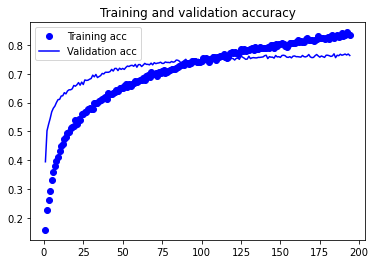

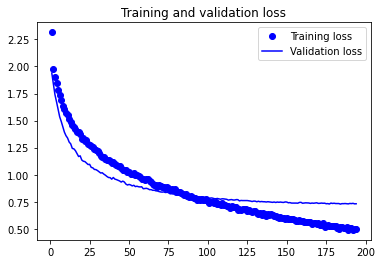

In [111]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()